# Transfer AE

_Use an autoencoder pre-trained on many sources as tranfer-learning preprocessing (feature extractor)._

## What?

![transferAE](transferAE.jpg)

## Why?

* Toute donnée est bonne à prendre (data driven). Les datasets s'entraident malgré la différence de leurs tâches. C'est la similitude entre les P(X) qui nous intéresse en premier lieu et aide par la suite à calculer les P(y|X) respectifs. Ainsi on peut tirer un avantage de données de sources très variées (different shapes and tasks).

* **Hypothèse : Il y a des connaissances générales communes à des données d'apparence éloignées.** L'espace des possibles est extrêmement grand. La "fenêtre" (sous-espace) ouverte par les données est très précises au final donc toute donnée affine un modèle (e.g. autoencoder). Autrement dit, l'ensemble des entrées plausibles est très petit.

* En gros on compresse des données pour les emmener avec soit.

**Plasticité : taux d'apprentissage de l'encoder (notamment pendant l'apprentissage d'un modèle).**

Pas forcément besoin d'une plasticité élevée pour bien généraliser?


L'AE apprend quelque chose de beaucoup plus général qu'un discriminant sur les données car il doit reconstituer l'information et non pas simplement répondre à une question dessus. **C'est une bonne chose pour généraliser mais il s'agit d'un problème beaucoup plus difficile, l'entrainement pourrait donc s'avérer moins efficace.**


## How?

# 1. Input shaper

On souhaite que le modèle puisse gérer des input data de differentes shapes.

* Soit un réseau capable de gerer des entrées de taille différentes;
* Soit un processing qui les mets au même format (padding and/or resizing)


#### One shape to rule them all

4D tensor : (row_count, col_count, channel, time)

In [ ]:
# TODO : put imports and loading functions in utilities
# Imports
import os
import sys
import tensorflow as tf
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
Model = tf.keras.models.Model
Sequential = tf.keras.models.Sequential
Input, Dense, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, UpSampling2D, UpSampling3D, Flatten, Reshape, Dropout = tf.keras.layers.Input, tf.keras.layers.Dense, tf.keras.layers.Conv2D, tf.keras.layers.Conv3D, tf.keras.layers.MaxPooling2D, tf.keras.layers.MaxPooling3D, tf.keras.layers.UpSampling2D, tf.keras.layers.UpSampling3D, tf.keras.layers.Flatten, tf.keras.layers.Reshape, tf.keras.layers.Dropout
regularizers = tf.keras.regularizers
load_model = tf.keras.models.load_model
from utilities import *
sys.path.append('/home/adrien/Documents/autodl/codalab_competition_bundle/AutoDL_starting_kit/AutoDL_ingestion_program/')
from dataset import AutoDLDataset

In [33]:
# Parameters
models_path = 'models'
data_path = 'data'
load = True
save = True
verbose = False
autoencoder_name = 'autoencoder'
autoencoder_path = os.path.join(models_path, autoencoder_name+'.h5')
model_name = 'model'
model_path = os.path.join(models_path, model_name+'.h5')

In [25]:
# Load a dataset
dataset_name = 'munster'
input_dir = os.path.join(data_path, dataset_name)
basename = dataset_name + '.data' # why?
D_train = AutoDLDataset(os.path.join(input_dir, basename, 'train'))
D_test = AutoDLDataset(os.path.join(input_dir, basename, 'test'))
x_train, y_train = input_fn(D_train.get_dataset())
x_test, y_test = input_fn(D_test.get_dataset())

(1, 28, 28, 1)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


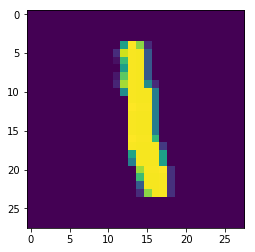

In [26]:
# Tests, visualization
with tf.Session() as sess:
    for _ in range(4):
        tensor_4d, labels = sess.run(x_train), sess.run(y_train)
        
input_shape = tensor_4d.shape[1:]
print(input_shape)
print(labels)
plt.imshow(tensor_4d.reshape((28,28))) #((32,32,3)))

# 2. Autoencoder

Unsupervised, no task. Train on every datasets.

Plutôt que d'avoir un modèle génératif qui permet de faire de l'augmentation de données, celui-ci apprend une représentation abstraite des données.

In [44]:
# Load or initialize autoencder
if os.path.isfile(autoencoder_path) and load:
    autoencoder = load_model(autoencoder_path)
    print('{} loaded.'.format(autoencoder_name))

else:
    kernel = (1, 3, 3)
    pool = (1, 2, 2)
    strides = (2,2,2)
    autoencoder = Sequential()

    # Encoder Layers
    autoencoder.add(Conv3D(16, kernel, activation='relu', padding='same', input_shape=input_shape))
    autoencoder.add(MaxPooling3D(pool, padding='same'))
    autoencoder.add(Conv3D(8, kernel, activation='relu', padding='same'))
    autoencoder.add(MaxPooling3D(pool, padding='same'))
    autoencoder.add(Conv3D(8, kernel, strides=strides, activation='relu', padding='same'))

    # Flatten encoding for visualization
    autoencoder.add(Flatten())
    autoencoder.add(Reshape((1, 4, 4, 8)))

    # Decoder Layers
    autoencoder.add(Conv3D(8, kernel, activation='relu', padding='same'))
    autoencoder.add(UpSampling3D(pool))
    autoencoder.add(Conv3D(8, kernel, activation='relu', padding='same'))
    autoencoder.add(UpSampling3D(pool))
    autoencoder.add(Conv3D(16, kernel, activation='relu'))
    autoencoder.add(UpSampling3D(pool))
    autoencoder.add(Conv3D(1, kernel, activation='sigmoid', padding='same'))
    print('{} initialized.'.format(autoencoder_name))
    
    if verbose:
        autoencoder.summary()

autoencoder initialized.


In [46]:
# Define encoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten', 5).output)

if verbose:
    encoder.summary()

In [88]:
# Train and save autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=1, steps_per_epoch=10000, validation_data=(x_test, x_test), validation_steps=1000)

if save:
    autoencoder.save(autoencoder_path)
    print('{} saved.'.format(autoencoder_name))

Epoch 1/1
10000/10000 [==============================] - 84s 8ms/step - loss: 0.1027 - val_loss: 0.0972
autoencoder saved.


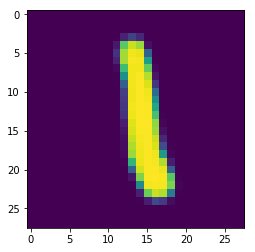

In [89]:
reconstructed_tensor_4d = autoencoder.predict(tensor_4d)[0]
plt.imshow(reconstructed_tensor_4d.reshape((28,28)))

# 3. Model

Un discriminant unique pour chaque problème de chaque dataset.

In [80]:
# Load or define model
# TODO : decide if it loads the encoder part
if os.path.isfile(model_path) and load:
    model = load_model(model_path)
    print('{} loaded.'.format(model_name))

else:
    model = Sequential()
    model.add(encoder)
    model.add(Dense(512, activation=tf.nn.relu))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation=tf.nn.sigmoid))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print('{} initialized.'.format(model_name))
    
if verbose:
    model.summary()

model initialized.


In [82]:
# Train, save and evaluate model
model.fit(x_train, y_train, epochs=1, steps_per_epoch=10000)
print(model.evaluate(x_test, y_test, steps=5000))

if save:
    model.save(model_path)
    print('{} saved.'.format(model_name))

Epoch 1/1
5000/5000 [==============================] - 7s 1ms/step
[0.0, 0.0956]
model saved.


In [78]:
# Model : SVM
#from sklearn.svm import SVC

#clf = SVC(C=6, kernel='poly')

# extract features
#features_train = encoder.predict(x_train, steps=1)
#features_test = encoder.predict(x_test, steps=1)

#clf.fit(features_train, y_train)
#clf.score(features_test, y_test)